This notebook loads a pre-trained PFN network and attacks it with the fast-gradient-sign-method (FGSM).  Additionally, a network is trained that computes a set of high-level observables as a bottleneck in the network:

(jet constituents) $\rightarrow$ (high-level observables) $\rightarrow$ (fully connected network) $\rightarrow$ (0,1)

In both cases, the attack is performed at the level of jet constituents.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras import callbacks
from keras.layers import Lambda, Dense
import itertools as it

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import util, defs, models

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
bg_consts, sig_consts, bg_jets, sig_jets = util.load_data(path='.', jet_pt_min=0.36, jet_mass_min=0.072)

print(bg_consts.shape)
print(sig_consts.shape)

(124708, 64, 3)
(191465, 64, 3)


In [5]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

print("Training set:  ", X_train.shape)
print("Validation set:", X_val.shape)

Training set:   (212004, 64, 3)
Validation set: (37412, 64, 3)


In [6]:
benchmark_LL_PFN = keras.models.load_model('v1models/model_benchmark_PFN_64_l64_center_grace.h5',custom_objects={"tf":tf,"CenterJet":util.CenterJet})
benchmark_HL_loaded = keras.models.load_model('v1models/model_benchmark_HL_calc_64.h5',
                              custom_objects={'JetVector':util.JetVector,
                                              'JetECF':util.JetECF,
                                              'tf':tf})

In [7]:
def to_categorical_layer(x):
    return K.concatenate([1.-x, x], axis=1)

tocategorical = Sequential()
tocategorical.add(Lambda(to_categorical_layer))

AUC_before = []
AUC_after = []

AUC_HL_before = []
AUC_HL_after = []

njet_up = 500*3

epsilonsPT = (1e-3,0.,0.)
epsilonPT = K.reshape(K.constant(epsilonsPT), (1,1,3))

epsilonsANGLE = (0.,1e-3,1e-3)
epsilonANGLE = K.reshape(K.constant(epsilonsANGLE), (1,1,3))

nstep = 10 #100
target_class = 1
target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

for Nconstits in [64]: #]range(16,65,8):

    print(Nconstits)
    
    ############
    def to_upsample(x):
        paddings = tf.constant([[0, 0], [0, 64-Nconstits], [0,0]])
        tpad = tf.pad(x, paddings, "CONSTANT")
        return tpad

    upsample_network = Sequential()
    upsample_network.add(Lambda(to_upsample,input_shape=(Nconstits,3),output_shape=(64,3)))
    wrapper_PFN_from_upsample = Model(inputs=upsample_network.input,outputs=tocategorical(benchmark_LL_PFN(upsample_network.output)))

    ############

    def to_upsample2(x):
        paddings = tf.constant([[0, 0], [0, 64-Nconstits], [0,0]])
        tpad = tf.pad(x, paddings, "CONSTANT")
        return tpad

    upsample_network2 = Sequential()
    upsample_network2.add(Lambda(to_upsample2,input_shape=(Nconstits,3),output_shape=(64,3)))
    wrapper_HL_from_upsample = Model(inputs=upsample_network2.input,outputs=tocategorical(benchmark_HL_loaded(upsample_network2.output)))
    
    ############

    x_NN_up = X_val[y_val==target_class][:njet_up][:,0:Nconstits,:]
    x_adv_NN_up = x_NN_up.copy()     
    
    x_NN_up_HL = X_val[y_val==target_class][:njet_up][:,0:Nconstits,:]
    x_adv_NN_up_HL = x_NN_up_HL.copy()
    
    AUC_before+=[roc_auc_score(to_categorical(np.concatenate([y_val[y_val!=target_class],np.ones(len(x_adv_NN_up))]),2), np.concatenate([wrapper_PFN_from_upsample.predict(X_val[:,0:Nconstits,:][y_val!=target_class]),wrapper_PFN_from_upsample.predict(x_adv_NN_up)]))]
    AUC_HL_before+=[roc_auc_score(to_categorical(np.concatenate([y_val[y_val!=target_class],np.ones(len(x_adv_NN_up_HL))]),2), np.concatenate([wrapper_HL_from_upsample.predict(X_val[:,0:Nconstits,:][y_val!=target_class]),wrapper_HL_from_upsample.predict(x_adv_NN_up_HL)]))]    

    sess = K.get_session()
    for istep in range(nstep):
        print("FGSM %d/%d..."%(istep+1,nstep))
        loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), wrapper_PFN_from_upsample.get_output_at(0))
        grads = K.gradients(loss, wrapper_PFN_from_upsample.get_input_at(0))
        delta = K.sign(grads[0])
        delta = tf.multiply(delta,tf.sign(tf.cast(x_NN_up,tf.float32))**2) #don't let it make new constituents
        x_adv_NN_up = x_adv_NN_up*(1.+epsilonPT*delta) + epsilonANGLE*delta
        x_adv_NN_up = sess.run(x_adv_NN_up, feed_dict={wrapper_PFN_from_upsample.get_input_at(0):x_NN_up})
        preds = wrapper_PFN_from_upsample.predict(x_adv_NN_up)[:,target_class]
        print("  avg:", preds.mean())
        pass
    AUC_after+=[roc_auc_score(to_categorical(np.concatenate([y_val[y_val!=target_class],np.ones(len(x_adv_NN_up))]),2), np.concatenate([wrapper_PFN_from_upsample.predict(X_val[:,0:Nconstits,:][y_val!=target_class]),wrapper_PFN_from_upsample.predict(x_adv_NN_up)]))]

    sess = K.get_session()
    for istep in range(nstep):
        print("FGSM %d/%d..."%(istep+1,nstep))
        loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), wrapper_HL_from_upsample.get_output_at(0))
        grads = K.gradients(loss, wrapper_HL_from_upsample.get_input_at(0))
        delta = K.sign(grads[0])
        delta = tf.multiply(delta,tf.sign(tf.cast(x_NN_up_HL,tf.float32))**2) #don't let it make new constituents
        x_adv_NN_up_HL = x_adv_NN_up_HL*(1.+epsilonPT*delta) + epsilonANGLE*delta
        x_adv_NN_up_HL = sess.run(x_adv_NN_up_HL, feed_dict={wrapper_HL_from_upsample.get_input_at(0):x_NN_up_HL})
        preds = wrapper_HL_from_upsample.predict(x_adv_NN_up_HL)[:,target_class]
        print("  avg:", preds.mean())
        pass
    AUC_HL_after+=[roc_auc_score(to_categorical(np.concatenate([y_val[y_val!=target_class],np.ones(len(x_adv_NN_up_HL))]),2), np.concatenate([wrapper_HL_from_upsample.predict(X_val[:,0:Nconstits,:][y_val!=target_class]),wrapper_HL_from_upsample.predict(x_adv_NN_up_HL)]))]       

64
FGSM 1/10...
  avg: 0.7489669
FGSM 2/10...
  avg: 0.7415144
FGSM 3/10...
  avg: 0.73396075
FGSM 4/10...
  avg: 0.72632194
FGSM 5/10...
  avg: 0.71856415
FGSM 6/10...
  avg: 0.71069664
FGSM 7/10...
  avg: 0.7027331
FGSM 8/10...
  avg: 0.69468296
FGSM 9/10...
  avg: 0.68655616
FGSM 10/10...
  avg: 0.67833
FGSM 1/10...
  avg: 0.64491785
FGSM 2/10...
  avg: 0.63867474
FGSM 3/10...
  avg: 0.6322316
FGSM 4/10...
  avg: 0.6256137
FGSM 5/10...
  avg: 0.61881
FGSM 6/10...
  avg: 0.61182386
FGSM 7/10...
  avg: 0.60468644
FGSM 8/10...
  avg: 0.5974101
FGSM 9/10...
  avg: 0.58997893
FGSM 10/10...
  avg: 0.58242446


In [8]:
#Let's add a random pertrubation.
Nrandom = len(y_val) #500
X_val_random = []
y_random = []
epsilonsPT = (1e-3,0.,0.)
epsilonsANGLE = (0.,1e-3,1e-3)
for i in range(Nrandom):
    delta = np.reshape(np.random.randint(0,2,64*3)*2-1,[64,3])
    X_val_random += [X_val[:,0:64,:][i]*(1.+nstep*delta*epsilonsPT) + nstep*delta*epsilonsANGLE]
    y_random += [y_val[i]]
    pass
y_random = np.array(y_random)
X_val_random = np.array(X_val_random)

In [9]:
def mymass_numpy(x):
    pT,eta,phi=np.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = np.sum(pT*np.cos(phi),axis=1)
    jpy = np.sum(pT*np.sin(phi),axis=1)
    jpz = np.sum(pT*(0.5*(np.exp(eta)-np.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = np.sum(pT*(0.5*(np.exp(eta)+np.exp(-eta))),axis=1) #no tf.cosh in my version
    jet_m2 = jpE**2-jpx**2-jpy**2-jpz**2
    jet_mass = np.sqrt(np.where(jet_m2>0,jet_m2,np.zeros_like(jet_m2))) #m
    return jet_mass #m
def mypT_numpy(x):
    pT,eta,phi=np.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = np.sum(pT*np.cos(phi),axis=1)
    jpy = np.sum(pT*np.sin(phi),axis=1)
    jet_pT2 = jpx**2+jpy**2
    jet_pT = np.sqrt(jet_pT2)
    return jet_pT #pT

In [11]:
jpt_val = mypT_numpy(X_val[:,0:64,:])
jpt_adv_HL = mypT_numpy(x_adv_NN_up_HL)
jpt_adv_LL = mypT_numpy(x_adv_NN_up)
jpt_rnd = mypT_numpy(X_val_random)

jmass_val = mymass_numpy(X_val[:,0:64,:])
jmass_adv_HL = mymass_numpy(x_adv_NN_up_HL)
jmass_adv_LL = mymass_numpy(x_adv_NN_up)
jmass_rnd = mymass_numpy(X_val_random)

JET_PT_MIN = 0.36*1.1 #saftey margin to allow for migrations
JET_MASS_MIN = 0.072*1.1 #saftey margin to allow for migrations

pass_val = (jpt_val>JET_PT_MIN)*(jmass_val>JET_MASS_MIN)
pass_adv_HL = (jpt_adv_HL>JET_PT_MIN)*(jmass_adv_HL>JET_MASS_MIN)
pass_adv_LL = (jpt_adv_LL>JET_PT_MIN)*(jmass_adv_LL>JET_MASS_MIN)
pass_rnd = (jpt_rnd>JET_PT_MIN)*(jmass_rnd>JET_MASS_MIN)

HL_preds_val = wrapper_HL_from_upsample.predict(X_val[:,0:64,:])
HL_preds_adv = wrapper_HL_from_upsample.predict(x_adv_NN_up_HL)
HL_preds_rnd = wrapper_HL_from_upsample.predict(X_val_random)

LL_preds_val = wrapper_PFN_from_upsample.predict(X_val[:,0:64,:])
LL_preds_adv = wrapper_PFN_from_upsample.predict(x_adv_NN_up)
LL_preds_rnd = wrapper_PFN_from_upsample.predict(X_val_random)

In [14]:
nsig_total = np.sum((y_val==1)*pass_val[:,0])
nsig_total_adv_HL = np.sum(pass_adv_HL[:,0])
nsig_total_adv_LL = np.sum(pass_adv_LL[:,0])
nbg_total = np.sum((y_val==0)*pass_val[:,0])

T = np.linspace(0,0.99,100)
Tl = range(len(T))

print("HL...")
HL_nsig_before = [sum(HL_preds_val[(y_val==1)*pass_val[:,0]][:,1] > T[i]) for i in Tl]/nsig_total
HL_nbg_before = [sum(HL_preds_val[(y_val==0)*pass_val[:,0]][:,1] > T[i]) for i in Tl]/nbg_total
HL_nsig_after = np.array([sum(HL_preds_adv[pass_adv_HL[:,0]][:,1] > T[i]) for i in Tl])/nsig_total_adv_HL
HL_nbg_after = HL_nbg_before
HL_nsig_rnd = [sum(HL_preds_rnd[(y_val==1)*pass_rnd[:,0]][:,1] > T[i]) for i in Tl]/nsig_total
HL_nbg_rnd = [sum(HL_preds_rnd[(y_val==0)*pass_rnd[:,0]][:,1] > T[i]) for i in Tl]/nbg_total

print("LL...")
LL_nsig_before = [sum(LL_preds_val[(y_val==1)*pass_val[:,0]][:,1] > T[i]) for i in Tl]/nsig_total
LL_nbg_before = [sum(LL_preds_val[(y_val==0)*pass_val[:,0]][:,1] > T[i]) for i in Tl]/nbg_total
LL_nsig_after = np.array([sum(LL_preds_adv[pass_adv_LL[:,0]][:,1] > T[i]) for i in Tl])/nsig_total_adv_LL
LL_nbg_after = LL_nbg_before
LL_nsig_rnd = [sum(LL_preds_rnd[(y_val==1)*pass_rnd[:,0]][:,1] > T[i]) for i in Tl]/nsig_total
LL_nbg_rnd = [sum(LL_preds_rnd[(y_val==0)*pass_rnd[:,0]][:,1] > T[i]) for i in Tl]/nbg_total

HL...
LL...


In [15]:
hl_sig_exp = HL_nsig_before/HL_nbg_before**0.5
hl_sig_obs = HL_nsig_after/HL_nbg_after**0.5
hl_sig_rnd = HL_nsig_rnd/HL_nbg_rnd**0.5

pfn_sig_exp = LL_nsig_before/LL_nbg_before**0.5
pfn_sig_obs = LL_nsig_after/LL_nbg_after**0.5
pfn_sig_rnd = LL_nsig_rnd/LL_nbg_rnd**0.5

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports un

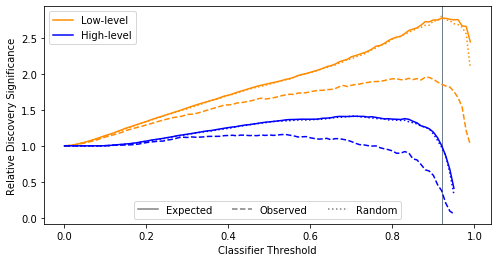

In [69]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray'),
                Line2D([0], [0], color='gray', ls='--'),
                Line2D([0], [0], color='gray', ls=':'),
               ]

plt.figure(figsize=(8,4))

l1, = plt.plot(T, pfn_sig_exp, color='darkorange', label=r'Low-level')
plt.plot(T, pfn_sig_obs, color='darkorange', ls='--')
plt.plot(T, pfn_sig_rnd, color='darkorange', ls=':')

plt.axvline(T[np.argmax(pfn_sig_exp)], ls='-', color='slategray', zorder=-1, lw=1)

l4, = plt.plot(T, hl_sig_exp, color='blue', label='High-level')
plt.plot(T, hl_sig_obs, color='blue', ls='--')
plt.plot(T, hl_sig_rnd, color='blue', ls=':')

plt.ylabel("Relative Discovery Significance")
plt.xlabel("Classifier Threshold")
first_legend = plt.legend(handles=[l1,l4], loc='upper left');
plt.gca().add_artist(first_legend)
plt.legend(custom_lines, ['Expected','Observed', 'Random'], loc='lower center', ncol=3);
plt.savefig("signif_undertraining_FGSM.pdf", bbox_inches='tight')

In [19]:
def ecf_numpy(N, beta, x, normalized=False):
    pt = x[:,:,0]
    eta = x[:,:,1:2]
    phi = x[:,:,2:]

    if N == 0:
        return np.ones(x.shape[0])
    elif N == 1:
        if normalized:
            return np.ones(x.shape[0])
        else:
            return np.sum(pt, axis=-1)
    
    # pre-compute the R_ij matrix
    R = np.concatenate([np.sqrt((eta[:,i:i+1]-eta)**2+(phi[:,i:i+1]-phi)**2) for i in range(x.shape[1])], axis=-1)
    # note, if dR = 0, these are either diagonal or padded entries that will get killed by pT=0 terms.
    # set these entries to some positive number to avoid divide-by-zero when beta<0
    R = np.clip(R, 1e-6, 999)
    
    # and raise it to the beta power for use in the product expression
    R_beta = R**beta
    
    # indexing tensor, returns 1 if i>j>k...
    eps = np.zeros((x.shape[1],)*N)
    for idx in it.combinations(range(x.shape[1]), r=N):
        eps[idx] = 1
        
    if N == 2:
        result = np.einsum('ij,...i,...j,...ij',eps,pt,pt,R_beta)
    elif N == 3:
        result =  np.einsum('ijk,...i,...j,...k,...ij,...ik,...jk',eps,pt,pt,pt,R_beta,R_beta,R_beta)
    else:
        # just for fun, the general case...
        # use ascii chars a...z for einsum indices
        letters = [chr(asc) for asc in range(97,97+N)]
        idx_expression = ''.join(letters) +',' + ','.join('...%s'%c for c in letters)
        for a,b in it.combinations(letters, r=2):
            idx_expression += ',...%s%s'%(a,b)
        #print(idx_expression)
        args = (eps,) + (pt,)*N + (R_beta,)*(N*(N-1)//2)
        result = np.einsum(idx_expression, *args)

    if normalized:
        result = result / ecf_numpy(1,beta,x,normalized=False)**N

    return result

In [39]:
ecf1_val = ecf_numpy(1, 2, X_val, normalized=False)
ecf2_val = ecf_numpy(2, 2, X_val, normalized=False) + K.epsilon()
ecf3_val = ecf_numpy(3, 2, X_val, normalized=False)

In [40]:
d2_val = ecf3_val * pow(ecf1_val, 3) / pow(ecf2_val, 3)

In [41]:
ecf1_val_adv = ecf_numpy(1, 2, x_adv_NN_up, normalized=False)
ecf2_val_adv = ecf_numpy(2, 2, x_adv_NN_up, normalized=False) + K.epsilon()
ecf3_val_adv = ecf_numpy(3, 2, x_adv_NN_up, normalized=False)

ecf1_val_adv_HL = ecf_numpy(1, 2, x_adv_NN_up_HL, normalized=False)
ecf2_val_adv_HL = ecf_numpy(2, 2, x_adv_NN_up_HL, normalized=False) + K.epsilon()
ecf3_val_adv_HL = ecf_numpy(3, 2, x_adv_NN_up_HL, normalized=False)

In [42]:
d2_val_adv = ecf3_val_adv * pow(ecf1_val_adv, 3) / pow(ecf2_val_adv, 3)
d2_val_adv_HL = ecf3_val_adv_HL * pow(ecf1_val_adv_HL, 3) / pow(ecf2_val_adv_HL, 3)

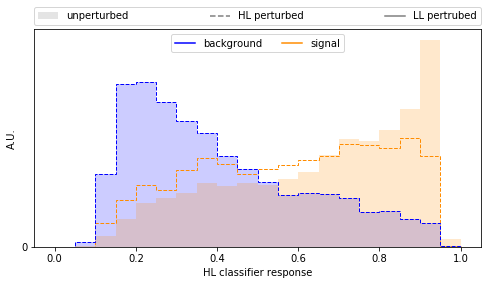

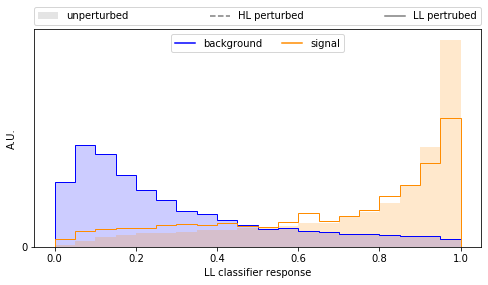

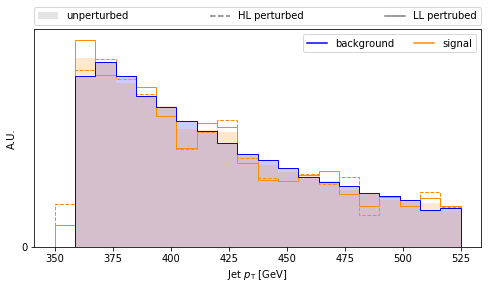

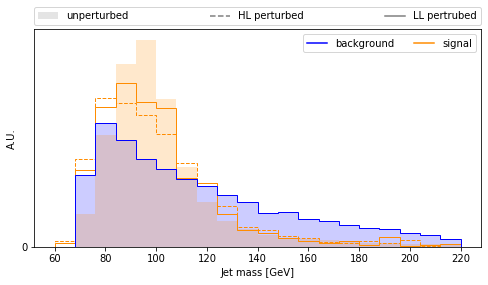

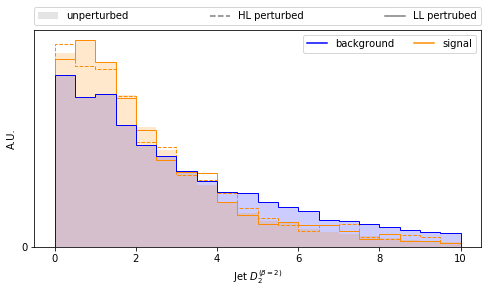

In [72]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
category_styles = [Line2D([0], [0], color='blue', label='background'),
                Line2D([0], [0], color='darkorange', label='signal'),
               ]
adv_styles = [Patch(facecolor='gray', alpha=0.2, label='unperturbed'),
              Line2D([0],[0], color='gray', label='HL perturbed', ls='--'),
              Line2D([0],[0], color='gray', label='LL pertrubed'),
               ]

mypass_vals = ((jpt_val>0.36)&(jmass_val>0.072))[:,0]

density=True

figsize=(8,4)

plt.figure(figsize=figsize)
b = np.linspace(0,1,21)
plt.hist(HL_preds_val[(mypass_vals)*(y_val==0)][:,1], color='blue', bins=b, alpha=0.2, density=density);
plt.hist(HL_preds_val[(mypass_vals)*(y_val==1)][:,1], color='darkorange', bins=b, alpha=0.2, density=density)
plt.hist(HL_preds_adv[:,1], color='darkorange', bins=b, histtype='step', ls='--', density=density);
plt.hist(HL_preds_val[(mypass_vals)*(y_val==0)][:,1], color='blue', bins=b, ls='--', density=density,histtype='step');

plt.yticks([0,])

l1 = plt.legend(handles=category_styles, loc='upper center', ncol=2)
plt.gca().add_artist(l1)
plt.legend(handles=adv_styles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

plt.xlabel("HL classifier response")
plt.ylabel("A.U.")

plt.savefig('adv_compare_HL_cls_FGSM.pdf', bbox_inches='tight')

plt.figure(figsize=figsize)
b = np.linspace(0,1,21)
plt.hist(LL_preds_val[(mypass_vals)*(y_val==0)][:,1], bins=b, color='blue', alpha=0.2, density=density);
plt.hist(LL_preds_val[(mypass_vals)*(y_val==1)][:,1], bins=b, color='darkorange', alpha=0.2, density=density)
plt.hist(LL_preds_val[(mypass_vals)*(y_val==0)][:,1], bins=b, color='blue', density=density,histtype='step');
plt.hist(LL_preds_adv[:,1], bins=b, color='darkorange', histtype='step', density=density);

plt.yticks([0,])

l1 = plt.legend(handles=category_styles, loc='upper center', ncol=2)
plt.gca().add_artist(l1)
plt.legend(handles=adv_styles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

plt.xlabel("LL classifier response")
plt.ylabel("A.U.")

plt.savefig('adv_compare_LL_cls_FGSM.pdf', bbox_inches='tight')

plt.figure(figsize=figsize)
b = np.linspace(350,525,21)
plt.hist(jpt_val[(mypass_vals)*(y_val==0)]*1e3, bins=b, color='blue', alpha=0.2, density=density);
plt.hist(jpt_val[(mypass_vals)*(y_val==1)]*1e3, bins=b, color='darkorange', alpha=0.2, density=density)
plt.hist(jpt_adv_HL*1e3, bins=b, color='darkorange', histtype='step', ls='--', density=density);
plt.hist(jpt_adv_LL*1e3, bins=b, color='darkorange', histtype='step', density=density);
plt.hist(jpt_val[(mypass_vals)*(y_val==0)]*1e3, bins=b, color='blue', histtype='step', density=density);

plt.yticks([0,])

l1 = plt.legend(handles=category_styles, loc='upper right', ncol=2)
plt.gca().add_artist(l1)
plt.legend(handles=adv_styles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

plt.xlabel(r"Jet $p_\mathrm{T}$ [GeV]")
plt.ylabel("A.U.")

plt.savefig('adv_compare_jpt_cls_FGSM.pdf', bbox_inches='tight')

plt.figure(figsize=figsize)
b = np.linspace(60,220,21)
plt.hist(jmass_val[(mypass_vals)*(y_val==0)]*1e3, bins=b, color='blue', alpha=0.2, density=density);
plt.hist(jmass_val[(mypass_vals)*(y_val==1)]*1e3, bins=b, color='darkorange', alpha=0.2, density=density)
plt.hist(jmass_adv_HL*1e3, bins=b, color='darkorange', histtype='step', ls='--', density=density);
plt.hist(jmass_adv_LL*1e3, bins=b, color='darkorange', histtype='step', density=density);
plt.hist(jmass_val[(mypass_vals)*(y_val==0)]*1e3, bins=b, color='blue', histtype='step', density=density);

plt.yticks([0,])

l1 = plt.legend(handles=category_styles, loc='upper right', ncol=2)
plt.gca().add_artist(l1)
plt.legend(handles=adv_styles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.);

plt.xlabel(r"Jet mass [GeV]")
plt.ylabel("A.U.");

plt.savefig('adv_compare_jmass_cls_FGSM.pdf', bbox_inches='tight')

plt.figure(figsize=figsize)
b = np.linspace(0,10,21)
d2scale=1.
plt.hist(d2_val[(mypass_vals)*(y_val==0)], bins=b, color='blue', alpha=0.2, density=density);
plt.hist(d2_val[(mypass_vals)*(y_val==1)], bins=b, color='darkorange', alpha=0.2, density=density)
plt.hist(d2_val_adv_HL, bins=b, color='darkorange', histtype='step', ls='--', density=density);
plt.hist(d2_val_adv, bins=b, color='darkorange', histtype='step', density=density);
plt.hist(d2_val[(mypass_vals)*(y_val==0)], bins=b, color='blue', histtype='step', density=density);

plt.yticks([0,])

l1 = plt.legend(handles=category_styles, loc='upper right', ncol=2)
plt.gca().add_artist(l1)
plt.legend(handles=adv_styles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.);

plt.xlabel(r"Jet $D_2^{(\beta=2)}$")
plt.ylabel("A.U.");

plt.savefig('adv_compare_jd2_cls_FGSM.pdf', bbox_inches='tight')